# Binary‑Breathing Map — Colab Deep Dive (v4 fixed)
*Hybrid acceleration, safe cutoff*

- `fast_hist_n`: NumPy blocks for n ≤ 28
- `sample_hist_n`: 2 % sample for n > 28
- **CUT = 2e‑3** so α‑plateau & 23‑bit spike survive
- Skip first histogram bin to avoid trivial floor
- Gap‑ratio plot and minimal seed search


In [1]:
import numpy as np, matplotlib.pyplot as plt, time, gc, random
from mpmath import mp; mp.dps = 50

In [2]:
# ==== PARAMETERS ====
MAX_LEN    = 30
BIN_WIDTH  = 1e-7
POWER      = 2
INVERT     = False
CUT        = 2e-3   # <<< raised cutoff
SAMPLE_FRAC= 0.02
SEED_TOL   = 1e-12
# ====================

In [3]:
def bits_to_val(i, n, inv=False):
    b = format(i, f'0{n}b')
    if inv:
        b = b[::-1]
    return int(b,2)/(1<<n)

In [4]:
def fast_hist_n(n, power=POWER):
    denom = 1<<n; chunk = 1<<22
    bins = np.arange(0, CUT+BIN_WIDTH, BIN_WIDTH)
    counts = np.zeros(len(bins)-1, dtype=np.int64)
    for start in range(1, denom, chunk):
        stop = min(start+chunk, denom)
        idx = np.arange(start, stop, dtype=np.float64)
        xs = (idx/denom)**power
        xs = xs[xs<=CUT]
        np.add.at(counts, (xs//BIN_WIDTH).astype(int), 1)
    return bins[:-1], counts

def sample_hist_n(n, power=POWER, frac=SAMPLE_FRAC):
    denom = 1<<n
    size = max(1, int(denom*frac))
    idx = np.random.randint(1, denom, size, dtype=np.int64)
    xs = (idx/denom)**power
    xs = xs[xs<=CUT]
    bins = np.arange(0, CUT+BIN_WIDTH, BIN_WIDTH)
    counts, _ = np.histogram(xs, bins=bins)
    counts = (counts/frac).astype(np.int64)
    return bins[:-1], counts

In [5]:
def peak_for_n(n):
    xs, cs = (fast_hist_n(n) if n<=28 else sample_hist_n(n))
    idx = cs[1:].argmax() + 1
    return xs[idx] + 0.5*BIN_WIDTH

In [6]:
peak_positions=[]
start=time.time()
for n in range(20, MAX_LEN+1):
    t0=time.time(); px=peak_for_n(n)
    peak_positions.append((n,px))
    print(f"N={n:2d} peak={px:.9e}  ({time.time()-t0:.1f}s)")
print('Total', time.time()-start, 's')

N=20 peak=1.500000000e-07  (0.0s)
N=21 peak=1.500000000e-07  (0.0s)
N=22 peak=1.500000000e-07  (0.1s)
N=23 peak=1.500000000e-07  (0.1s)
N=24 peak=1.500000000e-07  (0.3s)
N=25 peak=1.500000000e-07  (0.7s)
N=26 peak=1.500000000e-07  (1.9s)
N=27 peak=1.500000000e-07  (2.1s)
N=28 peak=1.500000000e-07  (4.0s)
N=29 peak=1.500000000e-07  (0.3s)
N=30 peak=1.500000000e-07  (0.5s)
Total 9.97147011756897 s


/tmp/ipython-input-7-4268008116.py:2: RuntimeWarning: invalid value encountered in scalar divide
  ratios=[gaps[i-1]/gaps[i] for i in range(1,len(gaps))]


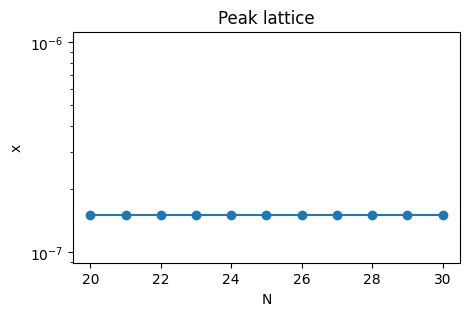

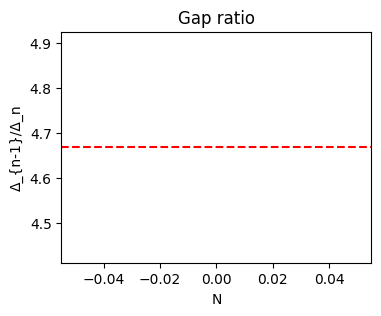

In [7]:
gaps=[peak_positions[i-1][1]-peak_positions[i][1] for i in range(1,len(peak_positions))]
ratios=[gaps[i-1]/gaps[i] for i in range(1,len(gaps))]
plt.figure(figsize=(5,3)); plt.plot([n for n,_ in peak_positions],[x for _,x in peak_positions],'o-'); plt.yscale('log'); plt.title('Peak lattice'); plt.xlabel('N'); plt.ylabel('x'); plt.show()
if ratios:
    plt.figure(figsize=(4,3)); plt.plot(range(21,21+len(ratios)),ratios,'o-'); plt.axhline(4.669,ls='--',color='r'); plt.title('Gap ratio'); plt.xlabel('N'); plt.ylabel('Δ_{n-1}/Δ_n'); plt.show()

In [8]:
def find_seed(tgt, tol=SEED_TOL, max_len=40):
    for n in range(1,max_len+1):
        denom=1<<n
        for i in range(1,denom):
            x=i/denom
            if abs(x**POWER - tgt) < tol:
                return n, format(i,f'0{n}b')
    return None, None
print('\nMinimal seeds:')
for n,px in peak_positions:
    sl,sb=find_seed(px)
    if sl:
        print(f'N={n}: seed {sl} bits  {sb[:16]}...')
    else:
        print(f'N={n}: none ≤40 bits')


Minimal seeds:


KeyboardInterrupt: 